## Q1

In [29]:
# part 2
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import pandas as pd
from sklearn.utils import resample
import scipy.stats as stats

# the data
url = "https://media.geeksforgeeks.org/wp-content/uploads/20240522154350/Fish[1].csv"
fish_data = pd.read_csv(url)

fish_data = fish_data[["Weight", "Height"]]
fish_data[["Weight", "Height"]] = fish_data[["Weight", "Height"]].subtract(fish_data[["Weight", "Height"]].min())
print(fish_data.head())
# only using weight and height here
wh = fish_data.values

            Weight     Length1     Length2     Length3      Height       Width
count   159.000000  159.000000  159.000000  159.000000  159.000000  159.000000
mean    398.326415   26.247170   28.415723   31.227044    8.970994    4.417486
std     357.978317    9.996441   10.716328   11.610246    4.286208    1.685804
min       0.000000    7.500000    8.400000    8.800000    1.728400    1.047600
25%     120.000000   19.050000   21.000000   23.150000    5.944800    3.385650
50%     273.000000   25.200000   27.300000   29.400000    7.786000    4.248500
75%     650.000000   32.700000   35.500000   39.650000   12.365900    5.584500
max    1650.000000   59.000000   63.400000   68.000000   18.957000    8.142000
   Weight   Height
0   242.0   9.7916
1   290.0  10.7516
2   340.0  10.6494
3   363.0  11.0016
4   430.0  10.7156


[1.1162267  1.69508288]
[1. 1.]


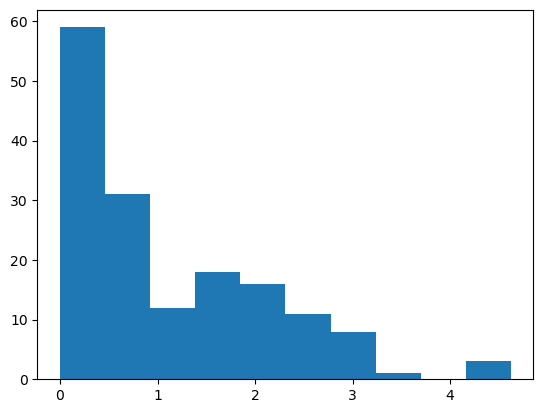

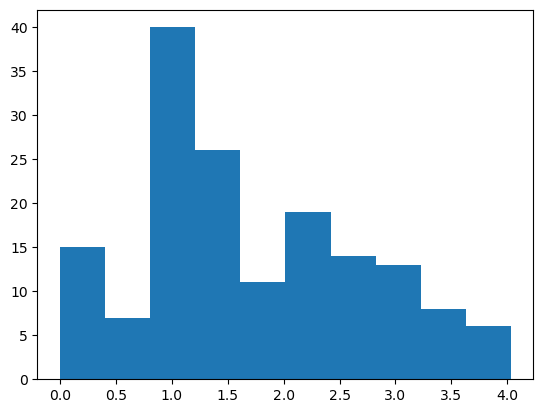

In [31]:
wh = wh/(np.std(wh, axis = 0))
print(np.mean(wh, axis = 0))
print(np.std(wh, axis = 0))

#weight
plt.hist(wh[:,0])
plt.show()

#height
plt.hist(wh[:,1])
plt.show()


In [52]:
# pymc copula ripped from https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
from numpy import inf
coords = {"obs_id": np.arange(wh.shape[0])}
with pm.Model(coords=coords) as marginal_model:

    # marginal estimation
    
    a_lam = pm.Gamma("a_lam", alpha = 2, beta = 2)
    b_mu = pm.Normal("b_mu", mu = 1, sigma = 2)
    b_sigma = pm.Exponential("b_sigma", lam=0.5)
    pm.Exponential("a", lam = a_alpha, observed=wh[:,0], dims="obs_id")
    pm.Normal("b", mu=b_mu, sigma=b_sigma, observed=wh[:,1], dims="obs_id")

    marginal_idata = pm.sample()

# point estimates
a_lam = marginal_idata.posterior["a_lam"].mean().item()
b_mu = marginal_idata.posterior["b_mu"].mean().item()
b_sigma = marginal_idata.posterior["b_sigma"].mean().item()
# transformations from observation space -> uniform space
__a = pt.exp(pm.logcdf(pm.Exponential.dist(lam = a_lam), wh[:,0]))
__b = pt.exp(pm.logcdf(pm.Normal.dist(mu=b_mu, sigma=b_sigma), wh[:,1]))
# uniform space -> multivariate normal space
_a = pm.math.probit(__a)
_b = pm.math.probit(__b)
# join into an Nx2 matrix
data = pt.math.stack([_a, _b,], axis=1).eval()
data[:,0][data[:,0] == -inf] = 0
coords.update({"param": ["a", "b"], "param_bis": ["a", "b"]})
with pm.Model(coords=coords) as copula_model:
    # Prior on covariance of the multivariate normal
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol",
        n=2,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True,
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("param", "param_bis"))

    # Likelihood function
    pm.MvNormal("N", mu=0.0, cov=cov, observed=data, dims=("obs_id", "param"))
    copula_idata = pm.sample()

az.summary(copula_idata, round_to = 5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_lam, b_mu, b_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
chol[0],1.04210,0.05766,0.93464,1.14954,0.00139,0.00094,1762.08976,2489.20836,1.00280
chol[1],0.80290,0.06279,0.68297,0.91689,0.00147,0.00105,1855.14021,1848.25944,1.00352
chol[2],0.57259,0.03216,0.51679,0.63608,0.00058,0.00052,3164.41845,2498.30866,1.00058
"chol_corr[0, 0]",1.00000,0.00000,1.00000,1.00000,0.00000,NaN,4000.00000,4000.00000,NaN
"chol_corr[0, 1]",0.81250,0.02681,0.75976,0.85991,0.00054,0.00044,2461.08801,2606.56613,1.00326
"chol_corr[1, 0]",0.81250,0.02681,0.75976,0.85991,0.00054,0.00044,2461.08801,2606.56613,1.00326
"chol_corr[1, 1]",1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,3642.07329,3268.36103,0.99995
chol_stds[0],1.04210,0.05766,0.93464,1.14954,0.00139,0.00094,1762.08976,2489.20836,1.00280
chol_stds[1],0.98720,0.05411,0.88794,1.08974,0.00126,0.00085,1906.08504,1907.84625,1.00271
"cov[a, a]",1.08929,0.12121,0.87356,1.32143,0.00292,0.00211,1762.08976,2489.20836,1.00280


/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/kdeplot.py:166: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(x_x, y_y, density, **contour_kwargs)


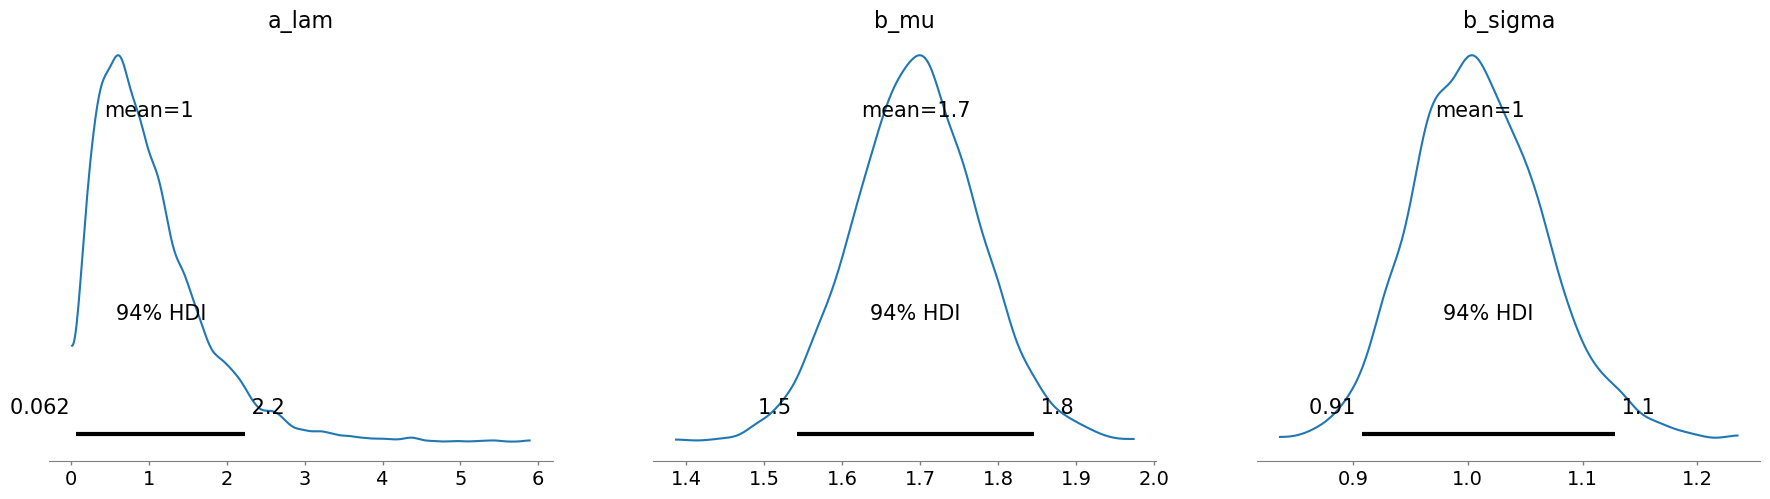

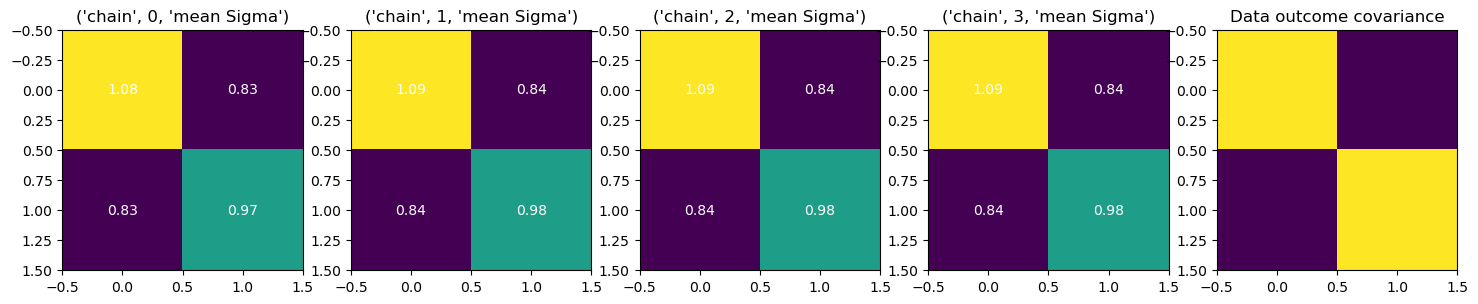

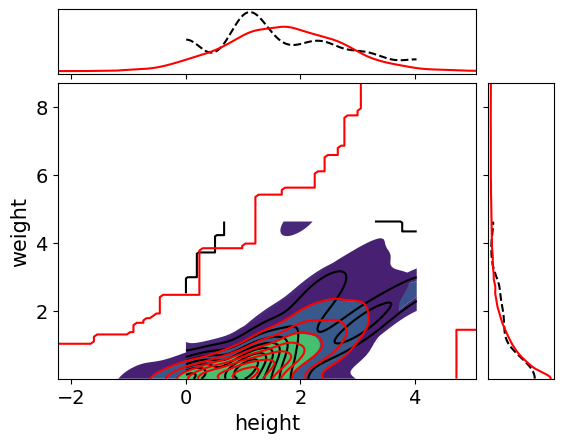

In [50]:
az.plot_posterior(
    marginal_idata, var_names=["a_lam", "b_mu", "b_sigma"])
fig,ax = plt.subplots(1,5,figsize=(18,4))
a_cov = np.cov(np.transpose(wh)) 

ax[-1].imshow(a_cov)
ax[-1].set_title(("Data outcome covariance"))
for chain in range(4):
    ax[chain].imshow(copula_idata.posterior['cov'].mean(axis=1)[chain])
    for i in range(2):
        for j in range(2):
            ax[chain].text(i,j,str(round(copula_idata.posterior['cov'].mean(axis=1)[chain].values[j,i],2)),
                             c='w', ha='center', va='center')
    ax[chain].set_title(("chain",chain,"mean Sigma"))
    
# data munging to extract covariance estimates from copula_idata in useful shape
d = {k: v.values.reshape((-1, *v.shape[2:])) for k, v in copula_idata.posterior[["cov"]].items()}

# generate (a, b) samples
ab = np.vstack([stats.multivariate_normal([0, 0], cov).rvs() for cov in d["cov"]])

# transform to uniform space
uniform_a = stats.norm().cdf(ab[:, 0])
uniform_b = stats.norm().cdf(ab[:, 1])

# transform to observation space
# estimated marginal parameters a_mu, a_sigma, b_scale are point estimates from marginal estimation.
ppc_a = stats.expon(scale=1/a_lam).ppf(uniform_a)
ppc_b = stats.norm(loc = b_mu, scale=b_sigma).ppf(uniform_b)

# plot data in black
ax = az.plot_pair(
    {"weight": wh[:,0], "height": wh[:,1]},
    marginals=True,
    # kind=["kde", "scatter"],
    kind="kde",
    scatter_kwargs={"alpha": 0.1},
    kde_kwargs=dict(
        contour_kwargs=dict(colors="k", linestyles="--"), contourf_kwargs=dict(alpha=0)
    ),
    marginal_kwargs=dict(color="k", plot_kwargs=dict(ls="--")),
)

# plot inferences in red
axs = az.plot_pair(
    {"weight": ppc_a, "height": ppc_b},
    marginals=True,
    # kind=["kde", "scatter"],
    kind="kde",
    scatter_kwargs={"alpha": 0.01},
    kde_kwargs=dict(contour_kwargs=dict(colors="r", linestyles="-"), contourf_kwargs=dict(alpha=0)),
    marginal_kwargs=dict(color="r"),
    ax=ax,
);

The estimates for the parameters of the distributions of weight and height are very close to their method of moments estimates, displaying that the parameter estimation step was successful. The sampled covariance structure is quite close to that of the weight and height data, suggesting that the final copula sampling step was also successful. The last figure shows that I probably should have used a truncated normal distribution instead of a plain normal distribution to model height. But other than that, the red estimates quite closely estimate the data distributions within the limitations of the chosen models.

#### part 3

Copulas are a joint distribution of variables where each marginal distribution follows a uniform(0,1) distribution. This is useful when paired with a parameterized transformation for each variable that gives us an meaningful distribution that may refect some data we have. \
The provided code and pymc do similar procedures on a high level: estimate parameters for each observed variable, transform each observed variables' data to follow a uniform(0,1) distribution, and then estimate the correlation structure among these variables through simuating a multivariate normal distribution and its covariance matrix.\
The provided code does some further accuracy increasing steps:
- it considers both the variable of interest and the variable next to it when estimating parameters, which (assuming that the 2 variable are positively correlated) should provide further information than just considering the variable of interest
- it doesn't use point estimates for the estimated parameters (unlike the pymc code that just takes the mean of all the sampled parameter estimates) when transforming the real data into the uniform space

So theoretically, the provided code should produce a more accurate copula than the pymc code due to the provided code considering more information and retaining the Bayesian spirit of considering the whole distribution of sampled parameters. 

#### part 4

Using this process, we could do generalized multivariate regression by creating a copula for all of our variables (both outcome and covariate). Then we can use the fact that the conditional distribution is proportional to the joint distribution (which is now a copula) to examine the relationship $E(Y|X,\beta) = X\beta$. This analogises to sampling from the copula to effectively generate new observations for our dataset, and using the new covariate observations as the $X$, estimating $\beta$ via the pymc-way, and treating the new outcome observations as $Y$. This is different from the established GLM framework by allowing for more accurate representation of data the doesn't follow mathematically nice distributions.

## Q2

In [1]:
# Q2
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from sklearn.utils import resample


url = "https://media.geeksforgeeks.org/wp-content/uploads/20240522154350/Fish[1].csv"
fish_data = pd.read_csv(url)

print(fish_data.describe())

fish_data[["Weight", "Height", "Width"]] = fish_data[["Weight", "Height", "Width"]].subtract(fish_data[["Weight", "Height", "Width"]].mean())
fish_data = pd.get_dummies(fish_data, columns=["Species"], prefix='', prefix_sep='', drop_first=True, dtype = int)
fish_data = pd.concat([pd.DataFrame([1]*fish_data.shape[0]), fish_data], axis = 1)
print(fish_data.head())

down10 = resample(fish_data,
             replace=True,
             n_samples=10,
             random_state=365)
down50 = resample(fish_data,
             replace=True,
             n_samples=50,
             random_state=365)
down100 = resample(fish_data,
             replace=True,
             n_samples=100,
             random_state=365)
y_lens = np.array(down10[["Length1", "Length2", "Length3"]])
fish_data = down10.drop(["Length1", "Length2", "Length3"], axis = 1)
X = np.matrix(fish_data)

            Weight     Length1     Length2     Length3      Height       Width
count   159.000000  159.000000  159.000000  159.000000  159.000000  159.000000
mean    398.326415   26.247170   28.415723   31.227044    8.970994    4.417486
std     357.978317    9.996441   10.716328   11.610246    4.286208    1.685804
min       0.000000    7.500000    8.400000    8.800000    1.728400    1.047600
25%     120.000000   19.050000   21.000000   23.150000    5.944800    3.385650
50%     273.000000   25.200000   27.300000   29.400000    7.786000    4.248500
75%     650.000000   32.700000   35.500000   39.650000   12.365900    5.584500
max    1650.000000   59.000000   63.400000   68.000000   18.957000    8.142000
   0      Weight  Length1  Length2  Length3    Height     Width  Parkki  \
0  1 -156.326415     23.2     25.4     30.0  2.549006 -0.397486       0   
1  1 -108.326415     24.0     26.3     31.2  3.509006 -0.111886       0   
2  1  -58.326415     23.9     26.5     31.1  3.406806  0.278614 

In [2]:

n,p = X.shape
m = y_lens.shape[1]
a_cov = np.cov(np.transpose(y_lens))

with pm.Model() as L2:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                     sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                     compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    y = pm.MvNormal('y', mu=X@betas, chol=L, observed=y_lens)   

    idata_l2 = pm.sample()
az.summary(idata_l2, round_to=5)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [packed_L, p, slab, betas]
>BinaryGibbsMetropolis: [spike]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1083 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 790 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 891 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1138 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",107.77932,21.17629,71.37011,148.01755,1.99021,0.66741,136.85657,1155.40024,1.04962
"Sigma[0, 1]",115.37954,21.45190,74.14577,150.91804,2.26211,0.52228,96.25767,1167.10940,1.03265
"Sigma[0, 2]",126.91943,24.38636,86.89762,171.89564,3.00426,1.49398,84.49191,212.79379,1.04105
"Sigma[1, 0]",115.37954,21.45190,74.14577,150.91804,2.26211,0.52228,96.25767,1167.10940,1.03265
"Sigma[1, 1]",129.56874,25.19945,84.81041,174.47550,2.22373,0.67901,113.93787,1451.09379,1.02865
"Sigma[1, 2]",139.36211,26.31438,95.93371,187.67643,2.92416,0.63456,85.83066,1086.07170,1.03471
"Sigma[2, 0]",126.91943,24.38636,86.89762,171.89564,3.00426,1.49398,84.49191,212.79379,1.04105
"Sigma[2, 1]",139.36211,26.31438,95.93371,187.67643,2.92416,0.63456,85.83066,1086.07170,1.03471
"Sigma[2, 2]",158.60235,33.12586,107.21269,221.23014,4.35015,2.16728,67.29690,504.66905,1.04373
"betas[0, 0]",0.61979,0.99428,-1.68285,2.16998,0.12149,0.08987,88.42826,25.55566,1.04237


In [4]:
with pm.Model() as spike_and_slab:

    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                     sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                     compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    
    q = pm.Beta('p', alpha=1, beta=1)
    spike = pm.Bernoulli('spike', p=q, shape = m) # spike
    slab = pm.Normal('slab', mu=0, sigma=100, shape = 3) # prior
    betas = pm.Normal('betas', mu=spike*slab, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X@betas, chol=L, observed=y_lens)   

    idata_ss = pm.sample()


az.summary(idata_ss, round_to=5)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [packed_L, p, slab, betas]
>BinaryGibbsMetropolis: [spike]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1073 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 712 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",105.55670,21.73606,68.25421,148.57189,0.68867,0.50505,1035.62902,1445.02055,1.00658
"Sigma[0, 1]",112.27786,21.64979,76.02795,154.54296,0.76706,0.47461,824.99923,1759.26497,1.00833
"Sigma[0, 2]",124.07581,23.99843,83.53733,171.75376,0.77599,0.65352,1008.38981,1246.78319,1.00844
"Sigma[1, 0]",112.27786,21.64979,76.02795,154.54296,0.76706,0.47461,824.99923,1759.26497,1.00833
"Sigma[1, 1]",125.94766,25.79407,80.23193,172.55413,1.07951,0.57637,547.36588,1629.53088,1.01260
"Sigma[1, 2]",135.70828,26.01472,93.72981,187.46161,0.91507,0.64873,838.18303,1676.05622,1.00735
"Sigma[2, 0]",124.07581,23.99843,83.53733,171.75376,0.77599,0.65352,1008.38981,1246.78319,1.00844
"Sigma[2, 1]",135.70828,26.01472,93.72981,187.46161,0.91507,0.64873,838.18303,1676.05622,1.00735
"Sigma[2, 2]",155.88142,31.94238,99.31572,213.62834,1.06944,0.78827,925.86568,1278.30071,1.00522
"betas[0, 0]",0.60216,0.96002,-1.20424,2.43983,0.02049,0.02243,2143.35279,1864.47035,1.00375


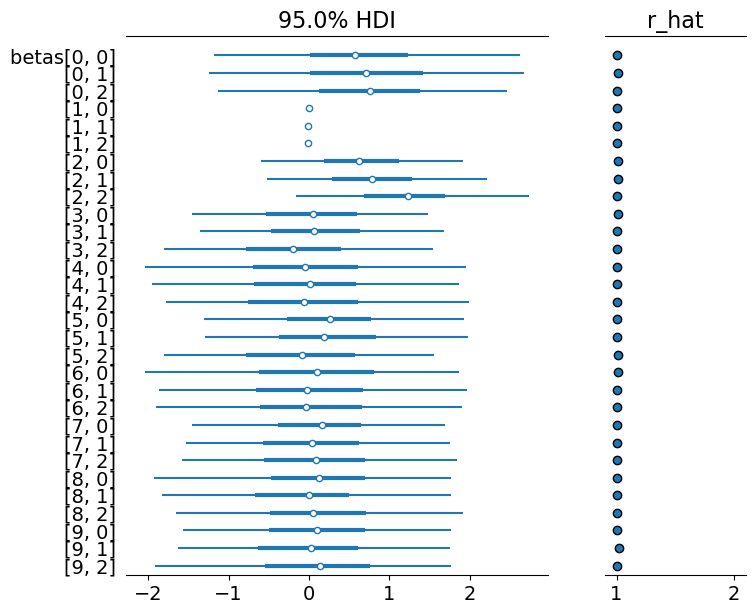

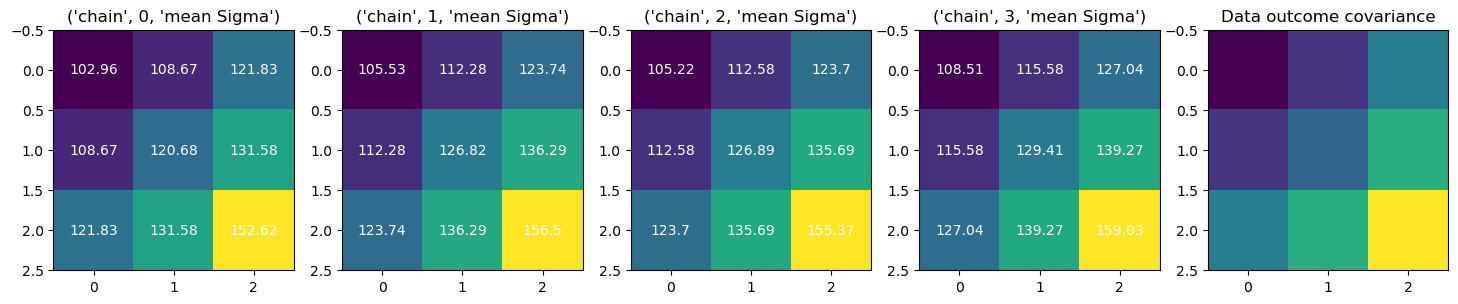

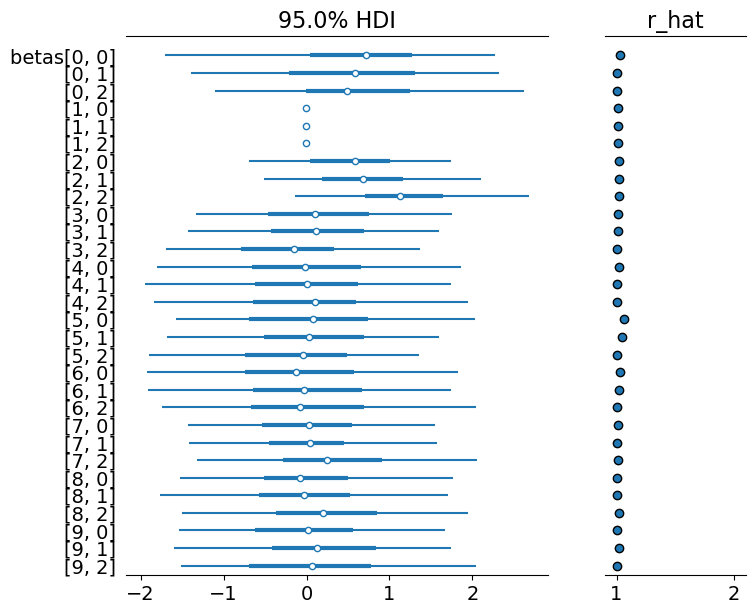

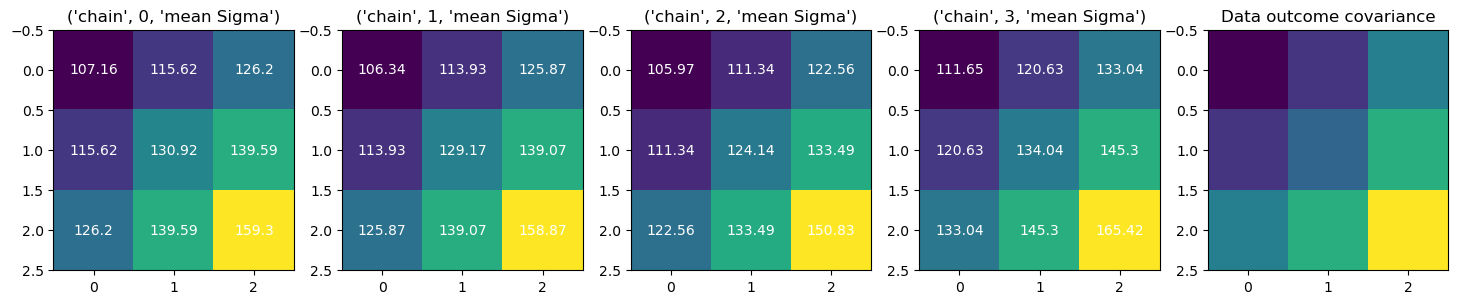

In [6]:
# spike+slab
az.plot_forest(idata_ss, var_names=["betas"], combined=True, hdi_prob=0.95, r_hat=True);
fig,ax = plt.subplots(1,5,figsize=(18,4))
a_cov = np.cov(np.transpose(y_lens)) 

ax[-1].imshow(a_cov)
ax[-1].set_title(("Data outcome covariance"))
for chain in range(4):
    ax[chain].imshow(idata_ss.posterior['Sigma'].mean(axis=1)[chain])
    for i in range(3):
        for j in range(3):
            ax[chain].text(i,j,str(round(idata_ss.posterior['Sigma'].mean(axis=1)[chain].values[j,i],2)),
                             c='w', ha='center', va='center')
    ax[chain].set_title(("chain",chain,"mean Sigma"))
# L2
az.plot_forest(idata_l2, var_names=["betas"], combined=True, hdi_prob=0.95, r_hat=True);
fig,ax = plt.subplots(1,5,figsize=(18,4))
a_cov = np.cov(np.transpose(y_lens)) 

ax[-1].imshow(a_cov)
ax[-1].set_title(("Data outcome covariance"))
for chain in range(4):
    ax[chain].imshow(idata_l2.posterior['Sigma'].mean(axis=1)[chain])
    for i in range(3):
        for j in range(3):
            ax[chain].text(i,j,str(round(idata_l2.posterior['Sigma'].mean(axis=1)[chain].values[j,i],2)),
                             c='w', ha='center', va='center')
    ax[chain].set_title(("chain",chain,"mean Sigma"))

None of the estimated effect sizes are significant for any of the outcomes on a 94% credible interval for both the spike and slab, and L2 regressions. There is some consistency between the spike and slab, and L2 regressions' beta estimates with height having the highest estimated mean effect size for all three outcomes compared to weight, width, and fish types. The estimated covariance matrices for both methods are similar to the data's empirical covariance. The main difference between the regressions is that the $\hat r$'s for the spike and slab chains are consistently closer to 1 than the L2 regression's. This suggests that the spike and slab helped stabilize estimates across chains via shrinkage.

I decided to reduce the number of data obsevations, $n$, in order to lower the computational time of sampling. This is likely the cause of the many divergences that occurred during sampling due to sparse data producing a more pathological surface than a fuller data distribution. Reducing $n$ also means that the full dataset is unlikely to be fully caputured and any inference from these regressions are unlikely to be fully generalizable to the entire dataset. However, with this fish dataset, using even just 10 observations still requires 15-25min for each of the L2 and, spike and slab regressions to run. I tried to run the spike and slab with 50 observation and it estimated 1hr+ for the regression to run. I suspect that these procedures would run a lot faster locally than on jupyterhub which would allow me to use all 159 observations if I wanted to seriously analyse this dataset. 

## Q3

In [2]:
import pytensor
import pytensor.tensor as pt
y_ls = down10[["Length1", "Length2", "Length3"]]
m = y_ls.shape[1]
fish_data = down10.drop([0,"Length1", "Length2", "Length3", "Parkki","Perch", "Pike", "Roach", "Smelt",  "Whitefish"], axis = 1)
n, p = fish_data.shape
with pm.Model(coords={"predictors": fish_data.columns.values}) as test_score_model:
    # Prior on error SD
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                     sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                     compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    # Global shrinkage prior
    sigma = pm.HalfNormal("sigma", 25, shape = m)
    tau = pm.HalfStudentT("tau", 2, 1 * sigma / np.sqrt(n), shape = m)
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 5, dims="predictors", shape = (p,m))
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors", shape = (p,m))
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau * lam * pt.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0, shape = m)

    scores = pm.MvNormal("scores", beta0 + pt.dot(fish_data.values, beta), chol=L, observed=y_ls.values)
    
    idata_hs = pm.sample(1000, tune=2000, random_seed=42)
    
az.summary(idata_hs, round_to = 5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 9369 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1859 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",0.68475,0.34051,0.18609,1.17265,0.05201,0.04121,24.42232,160.09387,1.12133
"Sigma[0, 1]",0.55846,0.31361,0.07015,0.95660,0.04791,0.04931,24.79952,236.26541,1.12730
"Sigma[0, 2]",0.51377,0.30100,-0.00882,1.02551,0.06259,0.02432,18.22451,124.63690,1.15796
"Sigma[1, 0]",0.55846,0.31361,0.07015,0.95660,0.04791,0.04931,24.79952,236.26541,1.12730
"Sigma[1, 1]",0.67654,0.43599,0.20461,1.31426,0.04174,0.09308,99.13963,85.42931,1.42148
"Sigma[1, 2]",0.44459,0.31078,-0.15772,0.90290,0.03916,0.03130,24.37403,293.63541,1.11649
"Sigma[2, 0]",0.51377,0.30100,-0.00882,1.02551,0.06259,0.02432,18.22451,124.63690,1.15796
"Sigma[2, 1]",0.44459,0.31078,-0.15772,0.90290,0.03916,0.03130,24.37403,293.63541,1.11649
"Sigma[2, 2]",1.11217,0.69570,0.29019,2.26396,0.02817,0.04814,530.64651,746.24232,1.45319
"beta[Weight, 0]",0.00542,0.00274,-0.00044,0.01070,0.00013,0.00034,377.14169,519.63059,1.14620


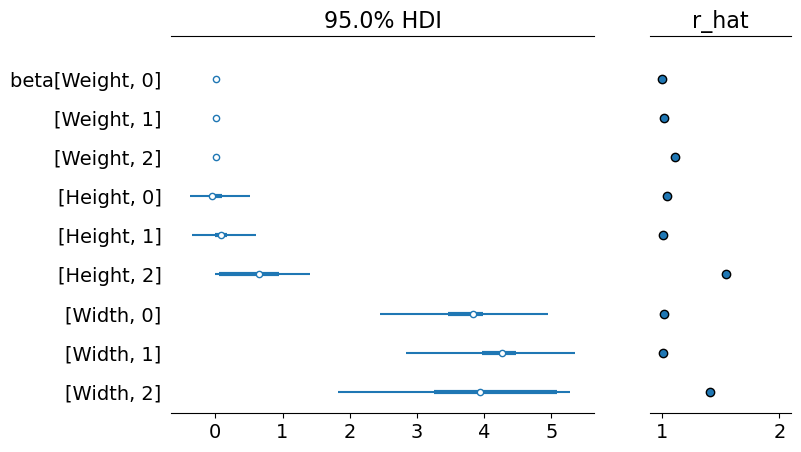

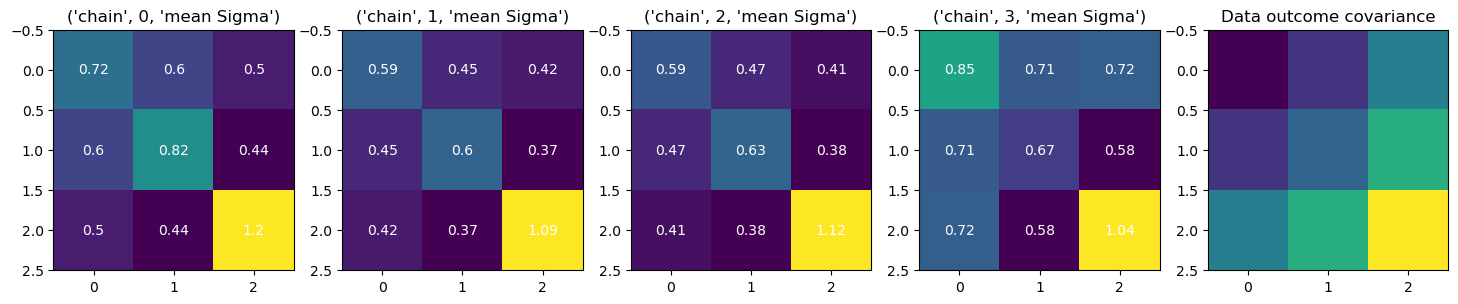

In [5]:
az.plot_forest(idata_hs, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);
fig,ax = plt.subplots(1,5,figsize=(18,4))
a_cov = np.cov(np.transpose(y_lens)) 

ax[-1].imshow(a_cov)
ax[-1].set_title(("Data outcome covariance"))
for chain in range(4):
    ax[chain].imshow(idata_hs.posterior['Sigma'].mean(axis=1)[chain])
    for i in range(3):
        for j in range(3):
            ax[chain].text(i,j,str(round(idata_hs.posterior['Sigma'].mean(axis=1)[chain].values[j,i],2)),
                             c='w', ha='center', va='center')
    ax[chain].set_title(("chain",chain,"mean Sigma"))

The horseshoe regression's estimated effect sizes for width on length1,2,3 are all significant on a 94% credible interval. Both weight and height are not estimated to being significant in predicting length1,2,3, except that height may have a very small effect size of length3. However, I am not inclined to trust these results since the $\hat r$'s from the horseshoe regression are all quite large, suggesting poor agreement among chains. This is reflected in the highly varying covariance matrices from the 4 chains (all of which noticeably differ from the data's covariance).\
While I cannot compare this horseshoe regression fully to the spike and slab regression performed in question 2 due to dropping all the fish types as predictors in this question, I can comment on the difference in $\hat r$'s between the 2 (keeping the fish types as predictors would have taken 3.5hr for the sampling to complete, compared to the 2.5hr that it took without fish types). The $\hat r$'s from the horseshoe prior are much larger than that of the spike and slab. This may be due to the horseshoe prior never actually putting any estimates to 0, unlike the spike and slab that puts a large density at 0. And since I am only working with 10 observations to keep run times down, the spike and slab is likely more appropriate since the number of parameters is larger than the number of data points that I have. The horseshoe is more likely to let some values in the rough surface defined by so few data points to be left unshrunk.